# **(Modelling and Evaluation Notebook)**

## Objectives

* Answer to business requirments2:
      *The client is interested in telling if a given cherry leaf  is infected by powdery mildew or not
## Inputs

* inputs/cherry_dataset/cherry-leaves/train* inputs/cherry_dataset/cherry-leaves//test* inputs/cherry_dataset/cherry-leaves/s/validatio* n
image shape embeddings.

## OutputImages distribution plot in train, validation, and test set.* 
Image augmentation.* 
Class indices to change prediction inference in labels* .
Machine learning model creation and trainin* g.
Save mod* el.
Learning curve plot for model performa* nce.
Model evaluation on pickle * file.
Prediction on the random image faves/traine. 



---

## Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

## Set Working Directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspaces/mildew-detection-in-cherry-leaves')
print("You set a new current directory"
)

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspaces/mildew-detection-in-cherry-leaves'

# Section 1

## Set Input directories

Set train, validation and test paths

In [5]:
cherry_data_dir = 'inputs/cherry_dataset/cherry-leaves'
train_path = cherry_data_dir + '/train'
val_path = cherry_data_dir + '/validation'
test_path = cherry_data_dir + '/test'

## Set output directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


## Set labels

In [7]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)

Project Labels: ['healthy', 'powdery_mildew']


## Set image shape

In [8]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

## Number of images in train, test and validation data

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




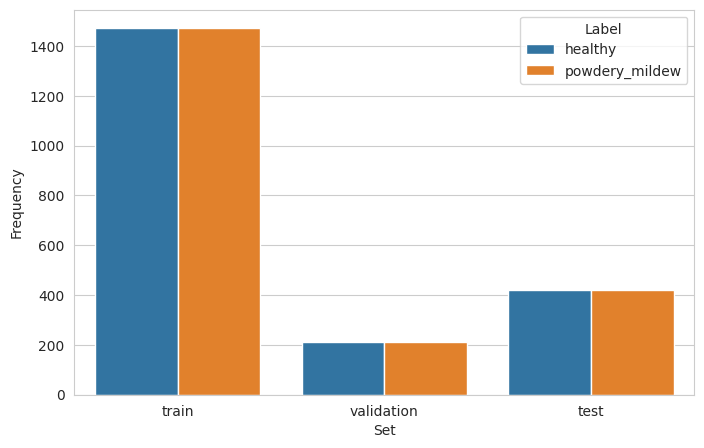

In [9]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(cherry_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(cherry_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

# Section 2

##  Image data augmentation

###  ImageDataGenerator

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
# Initialize ImageDataGenerator
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

* Augment training image dataset

In [12]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* Augment validation image dataset

In [13]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* Augment test image dataset

In [14]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* Plot augmented training image

(20, 256, 256, 3)


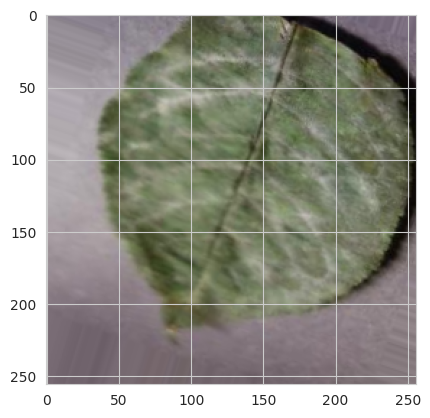

(20, 256, 256, 3)


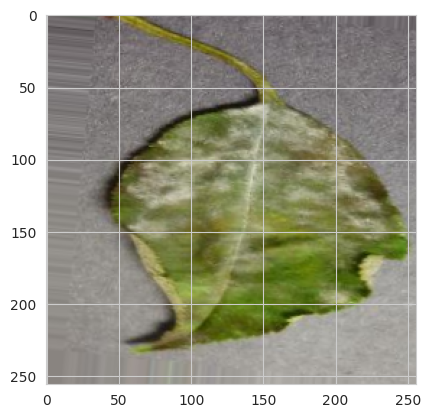

(20, 256, 256, 3)


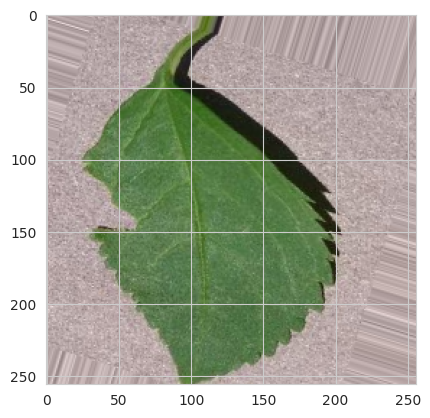

In [15]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

* Plot augmented validation and test images

(20, 256, 256, 3)


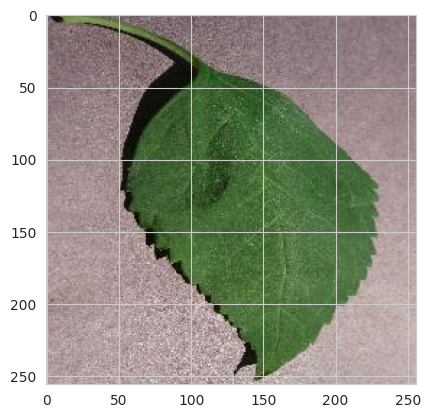

(20, 256, 256, 3)


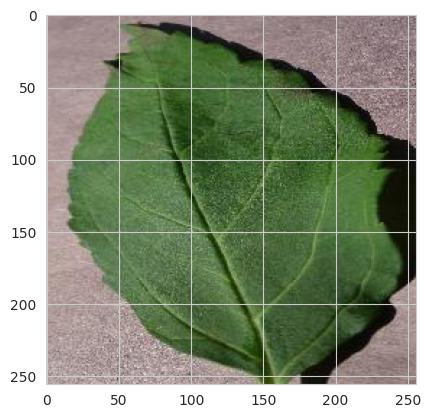

(20, 256, 256, 3)


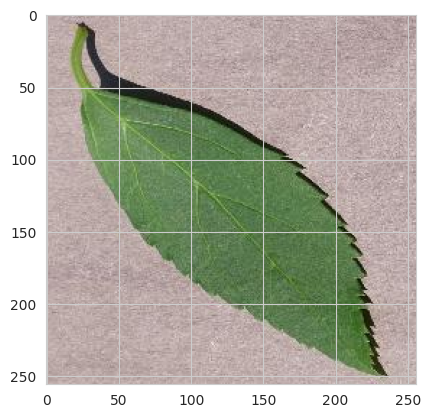

In [16]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(20, 256, 256, 3)


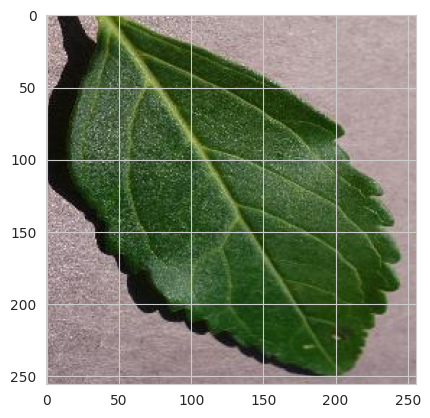

(20, 256, 256, 3)


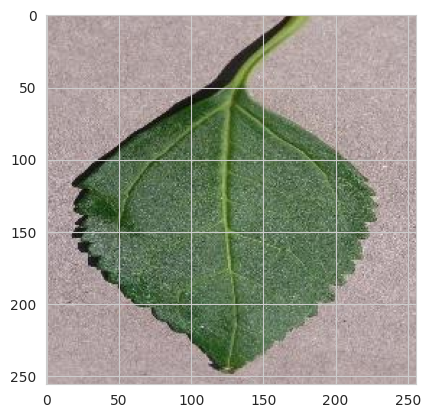

(20, 256, 256, 3)


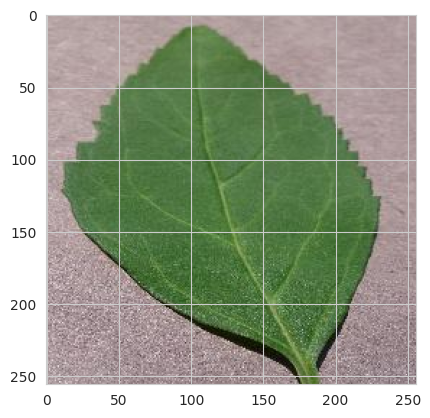

In [17]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

* Save class_indices

In [18]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")
['outputs/v1/class_indices.pkl']


['outputs/v1/class_indices.pkl']

# Section 3

## Model Creation

### ML Model

* Import model packages

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

* Model

In [20]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [21]:
# Model Summary
create_tf_model().summary()

2023-10-31 01:07:50.130844: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

In [22]:
# Early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [23]:
# Fit model for model Training 
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

2023-10-31 01:09:03.395005: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
147/147 [==============================] - 314s 2s/step - loss: 0.2562 - accuracy: 0.8868 - val_loss: 0.0359 - val_accuracy: 0.9881
Epoch 2/25
147/147 [==============================] - 238s 2s/step - loss: 0.0520 - accuracy: 0.9836 - val_loss: 0.0095 - val_accuracy: 1.0000
Epoch 3/25
147/147 [==============================] - 237s 2s/step - loss: 0.0418 - accuracy: 0.9887 - val_loss: 0.0266 - val_accuracy: 0.9929
Epoch 4/25
147/147 [==============================] - 254s 2s/step - loss: 0.0275 - accuracy: 0.9904 - val_loss: 0.0878 - val_accuracy: 0.9881
Epoch 5/25
147/147 [==============================] - 239s 2s/step - loss: 0.0187 - accuracy: 0.9945 - val_loss: 6.8059e-04 - val_accuracy: 1.0000
Epoch 6/25
147/147 [==============================] - 239s 2s/step - loss: 0.0974 - accuracy: 0.9689 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 7/25
147/147 [==============================] - 240s 2s/step - loss: 0.0312 - accuracy: 0.9911 - val_loss: 0.0272 - val_accuracy: 0.

In [24]:
# save model
model.save('outputs/v1/mildew_detector_model.h5')


## Model Performance

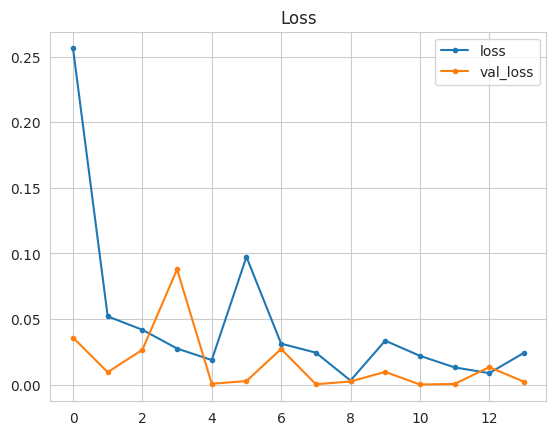

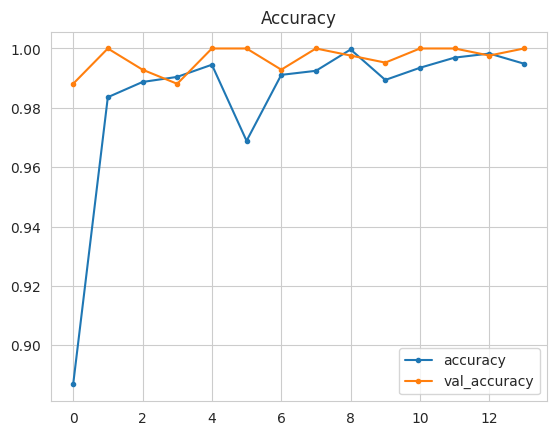

In [25]:
# model learning curve
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation

In [26]:
# load saved model
from keras.models import load_model
model = load_model('outputs/v1/mildew_detector_model.h5')

In [27]:
# Evaluate model on test
evaluation = model.evaluate(test_set)


43/43 [==============================] - 16s 374ms/step - loss: 0.0088 - accuracy: 0.9941


In [28]:
#save evaluation pickle
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

## Predit on new Data

Image shape: (256, 256), Image mode: RGB


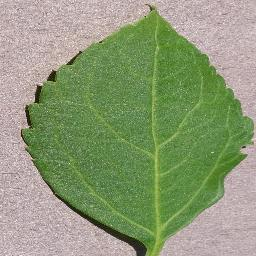

In [29]:
# load a rondom image as PIl
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[0]  # select Uninfected or Parasitised

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

In [30]:
# convert image to array and prepare for prediction
cherry_image = image.img_to_array(pil_image)
cherry_image = np.expand_dims(cherry_image, axis=0)/255
print(cherry_image.shape)

(1, 256, 256, 3)


In [31]:
# Predict class probabilities
pred_proba = model.predict(cherry_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)


0.9999995770436101
healthy


In [32]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   README.md
	modified:   jupyter_notebooks/Modeling and Evaluation note_note.ipynb
	modified:   outputs/v1/evaluation.pkl
	modified:   outputs/v1/labels_distribution.png
	modified:   outputs/v1/mildew_detector_model.h5
	modified:   outputs/v1/model_training_acc.png
	modified:   outputs/v1/model_training_losses.png

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	readme_images/moch_wsite.png

no changes added to commit (use "git add" and/or "git commit -a")


In [33]:
!git add .

In [34]:
!git commit -am" Add Modelling and Evaluation notebook"

[main 20dc597]  Add Modelling and Evaluation notebook
 8 files changed, 77 insertions(+), 131 deletions(-)
 rewrite outputs/v1/labels_distribution.png (99%)
 rewrite outputs/v1/model_training_acc.png (99%)
 rewrite outputs/v1/model_training_losses.png (99%)
 create mode 100644 readme_images/moch_wsite.png


In [35]:
!git push

Enumerating objects: 26, done.
Counting objects: 100% (26/26), done.
Delta compression using up to 4 threads
Compressing objects: 100% (12/12), done.
Writing objects: 100% (14/14), 70.99 MiB | 8.81 MiB/s, done.
Total 14 (delta 6), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (6/6), completed with 6 local objects.
remote: warning: See https://gh.io/lfs for more information.
remote: warning: File outputs/v1/mildew_detector_model.h5 is 85.07 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB
remote: warning: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.
To https://github.com/ujuadimora-dev/mildew-detection-in-cherry-leaves
   f5bed22..20dc597  main -> main


---

NOTE: Here mark the end of the Modelling